In [17]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [18]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [19]:
from rafdb_dataset import RAFDBDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
rafdb_dataset_train = RAFDBDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
                            img_dir='archive/RAF-DB/train/',
                            transform=transform)
# rafdb_dataset_train = RAFDBDataset(csv_file='archive/FER+/train_FER_labels.csv',
#                             img_dir='archive/FER+/train/',
#                             transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = RAFDBDataset(csv_file='dataset/vali_labels.csv',
                            img_dir='dataset/vali',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

rafdb_dataset_test = RAFDBDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
                            img_dir='archive/RAF-DB/test/',
                            transform=transform)
# rafdb_dataset_test = RAFDBDataset(csv_file='archive/FER+/test_FER_labels.csv',
#                             img_dir='archive/FER+/test/',
#                             transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [20]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [22]:
# Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [23]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = EmotionClassifier().to(device)

In [24]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

In [25]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10478086


In [26]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [27]:
# import torch.nn as nn
# import torch.nn.functional as F

# class VGGEmotionClassifier(nn.Module):
#     def __init__(self):
#         super(VGGEmotionClassifier, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(16384, 4096), 
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(1024, 6)  
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGGEmotionClassifier().to(device)

In [28]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [29]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # test 5/0.5 later

patience = 10
best_val_acc = 0  
patience_counter = 0

num_epochs = 40

In [31]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/40: 100%|██████████| 610/610 [00:52<00:00, 11.66it/s]


Epoch 1, Train Loss: 1.6011785337182343, Train Accuracy: 0.4753745126205623, Test Loss: 1.4323044856389364, Test Accuracy: 0.49602010892333476, Validation Loss: 2.1661044861141003, Validation Accuracy: 0.1669449081803005


Epoch 2/40: 100%|██████████| 610/610 [00:51<00:00, 11.86it/s]


Epoch 2, Train Loss: 1.43622547319678, Train Accuracy: 0.489534167863739, Test Loss: 1.4353316036860149, Test Accuracy: 0.49602010892333476, Validation Loss: 2.156328609115199, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 1 epochs.


Epoch 3/40: 100%|██████████| 610/610 [00:51<00:00, 11.76it/s]


Epoch 3, Train Loss: 1.4324128637548352, Train Accuracy: 0.489534167863739, Test Loss: 1.4264061220486959, Test Accuracy: 0.49602010892333476, Validation Loss: 2.176705943910699, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 2 epochs.


Epoch 4/40: 100%|██████████| 610/610 [00:52<00:00, 11.69it/s]


Epoch 4, Train Loss: 1.4347571664169187, Train Accuracy: 0.489534167863739, Test Loss: 1.4276211190223693, Test Accuracy: 0.49602010892333476, Validation Loss: 2.2001089014505086, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 3 epochs.


Epoch 5/40: 100%|██████████| 610/610 [00:52<00:00, 11.65it/s]


Epoch 5, Train Loss: 1.4323717862856193, Train Accuracy: 0.4893289554689103, Test Loss: 1.4281489141782124, Test Accuracy: 0.49602010892333476, Validation Loss: 2.108352447810926, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 4 epochs.


Epoch 6/40: 100%|██████████| 610/610 [00:52<00:00, 11.70it/s]


Epoch 6, Train Loss: 1.4309221069343754, Train Accuracy: 0.489534167863739, Test Loss: 1.4281335695584616, Test Accuracy: 0.49602010892333476, Validation Loss: 2.2158012327394987, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 5 epochs.


Epoch 7/40: 100%|██████████| 610/610 [00:52<00:00, 11.51it/s]


Epoch 7, Train Loss: 1.4308527413938865, Train Accuracy: 0.489534167863739, Test Loss: 1.4274051475524903, Test Accuracy: 0.49602010892333476, Validation Loss: 2.1670648643845007, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 6 epochs.


Epoch 8/40: 100%|██████████| 610/610 [00:53<00:00, 11.41it/s]


Epoch 8, Train Loss: 1.429504872247821, Train Accuracy: 0.489534167863739, Test Loss: 1.4268077023824055, Test Accuracy: 0.49602010892333476, Validation Loss: 2.1326606022684196, Validation Accuracy: 0.1669449081803005
No improvement in validation accuracy for 7 epochs.


Epoch 9/40: 100%|██████████| 610/610 [00:43<00:00, 13.92it/s]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (37,) and (24,)

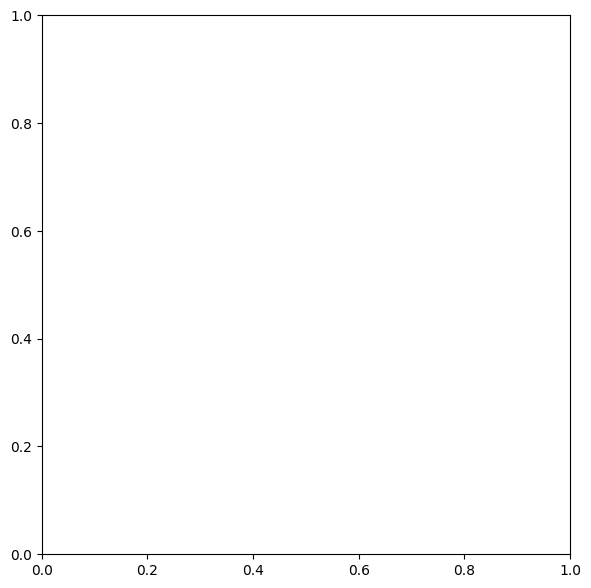

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(1, 38), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on RAF-DB') # change
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 38), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 38), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on RAF-DB') # change
plt.legend()

plt.show()

In [ ]:
df = pd.DataFrame({
    'Epoch': range(1, 18), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_FER_4layer.csv', index=False) # change this CSV